In [411]:
import numpy as np
import matplotlib.pyplot as plt
import solver.simple_hrl_solver as solver
from scipy.optimize import fsolve, curve_fit
import joblib as jl
import glob
import json

import matplotlib.cm
import matplotlib.colors
from matplotlib.lines import Line2D

### Define shared params. and some useful functions

In [2]:
N = 1000
Ts = [2,3,4,5,6,7,8,9,10,11,12]
K = 1
identical = False
v_norm = 0
w_angle = np.pi/2
v_angle = np.pi/4
lr_w = 1.
lr_wc = 0.
lr_v = 1.
nums_iter = [500000, 0]
update_frequency = 10

In [3]:


def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """

    def proj(u, v):
        """
        Return projection of v to u
        """
        return np.dot(v, u) / np.dot(u, u) * u

    V = np.random.normal(loc=0., scale=1.0, size=(K, N))
    U = np.zeros_like(V)

    ## Initialise u1 to v1
    U[0] = V[0]

    ## Gram-schomidt process
    for k in range(1, K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)

    return V, U

def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT / np.linalg.norm(VT)
    a = np.random.normal(loc=0., scale=1, size=(dim))
    b = np.random.normal(loc=0., scale=1, size=(dim))
    h = (b - a) - np.dot((b - a), VT_norm) * VT_norm
    v = np.cos(angle) * VT_norm + np.sin(angle) * h / np.linalg.norm(h)

    return v

def pos_exponential_func(x,a,b,c):
    return a * np.exp(b * x) + c

def neg_exponential_func(x,a,b,c):
    return a * np.exp(-b * x) + c

def log_func(x,a,c):
    return c * np.log(a*x)

def frac_func(x,a,b,c):
    
    return 1/(a*x+b)+c

def frac_exp(x,a,b):
    return 1/np.exp(a*x+b)
def frac_exp_neg(x,a,b,c):
    return -1/np.exp(a*x+b)

def exp(x,a,b,c):
    return np.exp(a*x+b)

def sigmoidal_func(x, a ,b, c, d):
    return c / (1 + np.exp(-b*(x-a))) + d

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def poly3d(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3 

def linear(x,a,b):
    return a*x+b


In [4]:
VT = np.ones(K)
VT = VT/np.linalg.norm(VT)
_,WT = gram_schmidt(N, K)
WS = np.array(control_VS(WT, np.pi/2) * np.sqrt(N), dtype = np.float64)


In [5]:
np.dot(WS[0], WT[0])/N

0.03778126713381031

In [6]:
_, W = gram_schmidt(N, 2)
WT=W[0,None]
WS0=W[1,None]
m = 1e-5
WS = np.array(m*WT + np.sqrt(1-m**2)*WS0)
WS.dtype

dtype('float64')

## Single Task

In [507]:
#T_models = {'sim':{}, 'ode':{}}
"""
nums_iter = [310000, 0]
for T in [11,12]:
    VS_sim = VT.copy()
    VS_ode = VT.copy()

    WS_sim = WS.copy()
    WS_ode = WS_sim.copy()

    single_task_sim = solver.CurriculumCompositionalTaskSimulator(input_dim= N, seq_len = T, num_task = 1, 
                                                                  identical = identical,  
                                                                  WT=WT, WS=WS_sim, 
                                                                  VT=VT, VS=VS_sim,  V_norm = v_norm)
    single_task_ode = solver.HRLODESolver(WT=WT, WS=WS_ode, VT=VT, VS=VS_ode,
                                          lr_ws = [lr_w, lr_wc], lr_v = lr_v,  
                                          N = N, seq_length = T,  V_norm = v_norm)
    single_task_sim.train(num_iter=nums_iter, update_frequency = 10, 
                      lr = {'lr_w': lr_w, 'lr_wc': lr_wc, 'lr_vc': lr_v} )
    single_task_ode.train(nums_iter=np.array(nums_iter), update_frequency = 10,)
    T_models['sim'][T] = single_task_sim
    T_models['ode'][T] = single_task_ode
"""

In [9]:
T_models=jl.load('single_task_T_models.jl')

In [10]:
fig=plt.figure(figsize=(5,5))
nes = [int(max_info[T][0]//10) for T in Ts]
for T, ne in zip(Ts, nes):
    
    print(T_models['ode'][T].history['phase1']['R'][0,0,0])
    plt.title(f'Single Task R (T={T})')
    #plt.plot(T_models['sim'][T].history['R'][:,0,0], c = 'gray')
    plt.plot(T_models['ode'][T].history['phase1']['R'][:,0,0], c = 'gray', ls = '--')

NameError: name 'max_info' is not defined

<Figure size 500x500 with 0 Axes>

0.0002028664485459595
0.00010617579909054464
5.781990426255069e-05
3.363955563552297e-05
2.1548779482050037e-05
1.5503227374272138e-05
1.248040185294897e-05
1.096897224978355e-05
1.021325096201232e-05
9.835387553266714e-06
9.646454585430527e-06


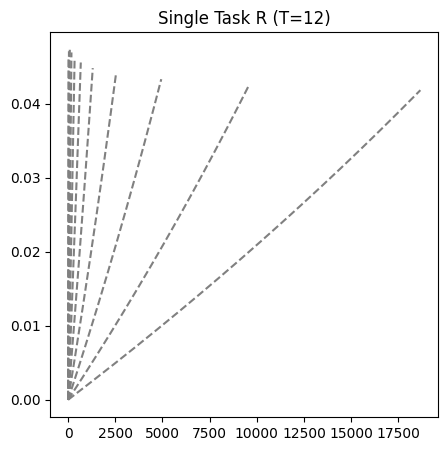

In [11]:
max_info ={2: [495, 0.1],
 3: [955, 0.1],
 4: [1849, 0.1],
 5: [3582, 0.1],
 6: [6947, 0.1],
 7: [13480, 0.1],
 8: [26168, 0.1],
 9: [50824, 0.1],
 10: [98751, 0.1],
 11: [191944, 0.1],
 12: [373223, 0.1]}
nes = [int(max_info[T][0]//10) for T in Ts]
fig=plt.figure(figsize=(5,5))
for T, ne in zip(Ts, nes):
    
    print(T_models['ode'][T].history['phase1']['R'][0,0,0])
    plt.title(f'Single Task R (T={T})')
    #plt.plot(T_models['sim'][T].history['R'][:int(ne*0.3),0,0], c = 'gray')
    plt.plot(T_models['ode'][T].history['phase1']['R'][:int(ne*0.5),0,0], c = 'gray', ls = '--')

/tmp/ipykernel_1920172/885185056.py:25: RuntimeWarning: divide by zero encountered in power
  return np.power(a*x,b)


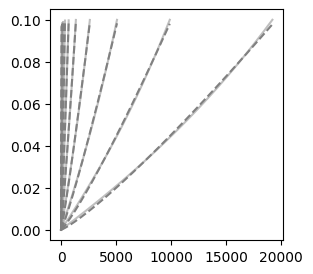

In [12]:
Ts=[2,3,4,5,6,7,8,9,10,11]
max_info ={2: [495, 0.1],
 3: [955, 0.1],
 4: [1849, 0.1],
 5: [3582, 0.1],
 6: [6947, 0.1],
 7: [13480, 0.1],
 8: [26168, 0.1],
 9: [50824, 0.1],
 10: [98751, 0.1],
 11: [191944, 0.1],
 12: [373223, 0.1]}

nes = [int(max_info[T][0]//10) for T in Ts]
popt_list = []
def inverse_poly2d(x,a,b):
    #return P_max*x/(x+np.exp(a+b*x))
    #return np.sqrt(1/(1-a*x/step_max-b*(x/step_max)**2))
    
    #return a*1e-5*(x)*np.exp(-b*((c-c)**2))
    #return a*x*2*np.log(b*x**2)
    return a*np.exp(b*x)-a

def polynomial(x, a,b):
    return np.power(a*x,b)

fig = plt.figure(figsize=(3,3))
for T, ne in zip(Ts, nes):
    try:
        xdata=np.arange(0,ne)
        ydata = T_models['ode'][T].history['phase1']['R'][np.arange(0,ne),0,0]
        T_fix = T
        P_max =max_info[T][1]
        step_max = ne
        p0=[1e-6,1]
        popt, pcov  = curve_fit(polynomial, xdata,ydata,p0=p0)
        yapprox = polynomial(xdata, *popt)
        popt_list.append(popt)
        plt.plot(xdata, yapprox,c = 'gray', ls = '--')
        plt.plot(xdata, ydata, c= 'gray', alpha = 0.5)
    except:
        print('fail')
popt_list = np.array(popt_list)

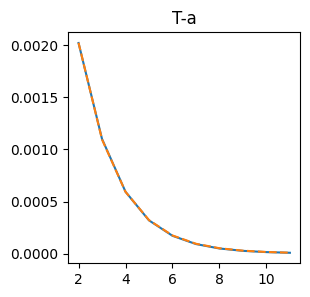

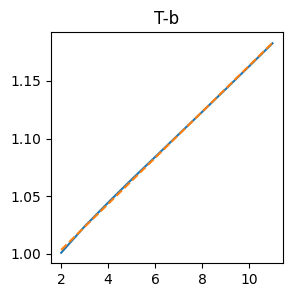

In [13]:
fig = plt.figure(figsize= (3,3))
popt_b, pcov_b  = curve_fit(frac_exp,Ts,popt_list[:,0], [1,1])
b_approx = frac_exp(np.array(Ts), *popt_b )
plt.title('T-a')
plt.plot(Ts, popt_list[:,0])
plt.plot(Ts,b_approx, ls = '--')

fig = plt.figure(figsize= (3,3))
popt_c, pcov_c = curve_fit(linear,np.array(Ts),popt_list[:,1],[1e-3,1e-1])
c_approx = linear(np.array(Ts), *popt_c)
plt.title('T-b')
plt.plot(Ts, popt_list[:,1])
plt.plot(Ts, c_approx, ls='--')


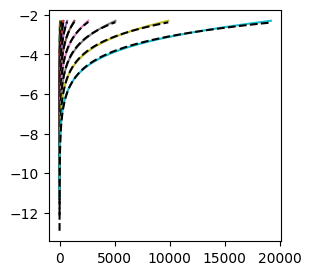

In [14]:
Ts=[2,3,4,5,6,7,8,9,10,11]
max_info ={2: [495, 0.1],
 3: [955, 0.1],
 4: [1849, 0.1],
 5: [3582, 0.1],
 6: [6947, 0.1],
 7: [13480, 0.1],
 8: [26168, 0.1],
 9: [50824, 0.1],
 10: [98751, 0.1],
 11: [191944, 0.1],
 12: [373223, 0.1]}

nes = [int(max_info[T][0]//10) for T in Ts]
popt_list = []
def direct_polynomial(x, m,n, p,q):
    
    return (p*T_fix+ q)*(m*T_fix + n + np.log(x))

fig = plt.figure(figsize=(3,3))
for T, ne in zip(Ts, nes):
    try:
        xdata= np.arange(1,ne)
        ydata = np.log(T_models['ode'][T].history['phase1']['R'][np.arange(1,ne),0,0])
        T_fix = T
        P_max =max_info[T][1]
        step_max = ne
        popt, pcov  = curve_fit(direct_polynomial, xdata,ydata)
        yapprox = direct_polynomial(xdata, *popt)
        popt_list.append(popt)
        plt.plot(xdata, ydata)
        plt.plot(xdata, yapprox,c = 'k', ls = '--')
        
    except:
        print('fail')
popt_list = np.array(popt_list)

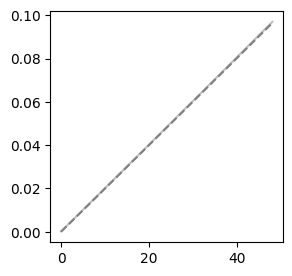

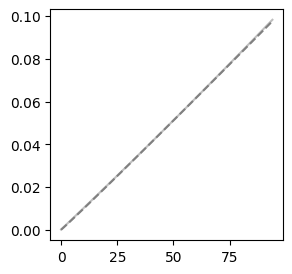

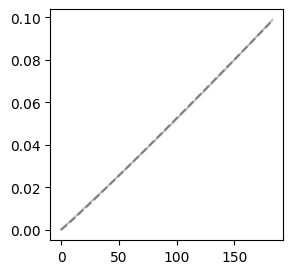

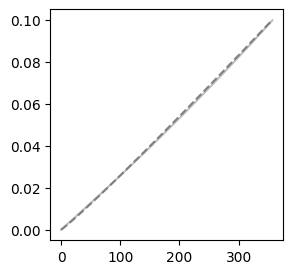

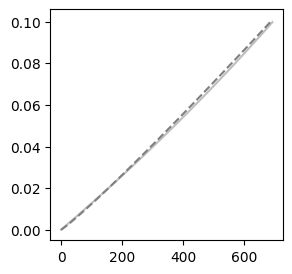

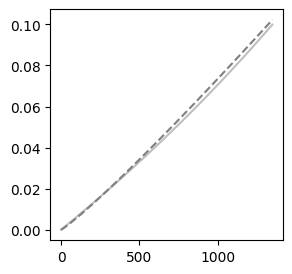

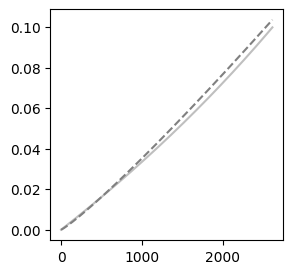

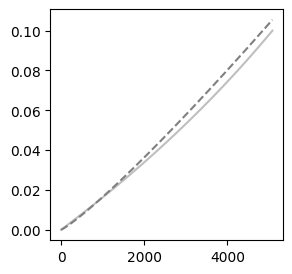

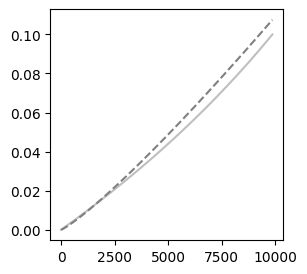

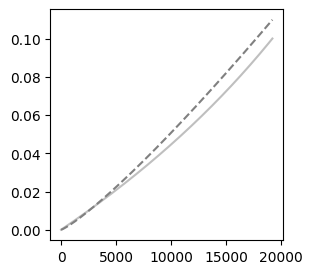

In [15]:
def polynomial_withT(x, T, popt_b, popt_c):
    a=frac_exp(T,*popt_b)
    b=linear(T,*popt_c)
    return polynomial(x, a,b)
i=0

for T, ne in zip(Ts, nes):
    fig = plt.figure(figsize=(3,3))
    xdata=np.arange(0, ne)
    ydata = T_models['ode'][T].history['phase1']['R'][np.arange(0,ne),0,0]
    yfit = polynomial_withT(xdata, T, popt_b, popt_c)
    plt.plot(xdata, yfit,c = 'gray', ls = '--')
    plt.plot(xdata, ydata, c= 'gray', alpha = 0.5)
    i+=1

## Compositional Task

In [18]:
def load_log(p):
    log =jl.load(p)
    args = json.load(open('/'.join(p.split('/')[:-1]) + '/args.json', 'r'))    
    return log, args

In [93]:
Ts = [2,3,4,5,6,7,8,9,10,11,12]
Ks = [2,3,4,5,6,7,8]

In [97]:
steps = {(2, 2): 1012,
 (3, 2): 1940,
 (4, 2): 3741,
 (5, 2): 7235,
 (6, 2): 14013,
 (7, 2): 27165,
 (8, 2): 52701,
 (9, 2): 102302,
 (10, 2): 198686,
 (11, 2): 386051,
 (12, 2): 750418,
 (2, 3): 1512,
 (3, 3): 2944,
 (4, 3): 5630,
 (5, 3): 10811,
 (6, 3): 21048,
 (7, 3): 40996,
 (8, 3): 79070,
 (9, 3): 153214,
 (10, 3): 299451,
 (11, 3): 577569,
 (12, 3): 1122575,
 (2, 4): 2034,
 (3, 4): 3842,
 (4, 4): 7444,
 (5, 4): 14633,
 (6, 4): 28007,
 (7, 4): 54742,
 (8, 4): 105040,
 (9, 4): 204321,
 (10, 4): 397912,
 (11, 4): 774352,
 (12, 4): 1509984,
 (2, 5): 2512,
 (3, 5): 4883,
 (4, 5): 9323,
 (5, 5): 18088,
 (6, 5): 35002,
 (7, 5): 68256,
 (8, 5): 133038,
 (9, 5): 256239,
 (10, 5): 497611,
 (11, 5): 967456,
 (12, 5): 1886505,
 (2, 6): 3090,
 (3, 6): 5835,
 (4, 6): 11142,
 (5, 6): 21741,
 (6, 6): 41962,
 (7, 6): 82418,
 (8, 6): 159735,
 (9, 6): 305767,
 (10, 6): 596778,
 (11, 6): 1166467,
 (12, 6): 2249680,
 (2, 7): 3496,
 (3, 7): 6834,
 (4, 7): 13300,
 (5, 7): 25890,
 (6, 7): 49378,
 (7, 7): 94989,
 (8, 7): 184251,
 (9, 7): 358004,
 (10, 7): 695194,
 (11, 7): 1360903,
 (12, 7): 2631711,
 (2, 8): 4059,
 (3, 8): 7725,
 (4, 8): 14913,
 (5, 8): 28895,
 (6, 8): 56064,
 (7, 8): 109614,
 (8, 8): 211661,
 (9, 8): 411599,
 (10, 8): 793703,
 (11, 8): 1545109,
 (12, 8): 3003451}

steps_indiv = {(2, 2): 712,
 (3, 2): 1382,
 (4, 2): 2694,
 (5, 2): 5260,
 (6, 2): 10281,
 (7, 2): 20106,
 (8, 2): 39338,
 (9, 2): 76990,
 (10, 2): 150724,
 (11, 2): 295151,
 (12, 2): 578104,
 (2, 3): 1002,
 (3, 3): 1856,
 (4, 3): 4379,
 (5, 3): 6776,
 (6, 3): 14477,
 (7, 3): 31408,
 (8, 3): 50768,
 (9, 3): 99562,
 (10, 3): 231991,
 (11, 3): 388850,
 (12, 3): 894222,
 (2, 4): 1593,
 (3, 4): 2278,
 (4, 4): 4535,
 (5, 4): 8764,
 (6, 4): 22677,
 (7, 4): 31659,
 (8, 4): 89412,
 (9, 4): 153381,
 (10, 4): 299082,
 (11, 4): 529482,
 (12, 4): 970144,
 (2, 5): 1815,
 (3, 5): 2961,
 (4, 5): 5958,
 (5, 5): 11232,
 (6, 5): 22972,
 (7, 5): 44597,
 (8, 5): 76880,
 (9, 5): 174385,
 (10, 5): 309383,
 (11, 5): 612712,
 (12, 5): 1639789,
 (2, 6): 1658,
 (3, 6): 2690,
 (4, 6): 7487,
 (5, 6): 12899,
 (6, 6): 24924,
 (7, 6): 45082,
 (8, 6): 121765,
 (9, 6): 201641,
 (10, 6): 497155,
 (11, 6): 765974,
 (12, 6): 1250733,
 (2, 7): 1763,
 (3, 7): 3784,
 (4, 7): 8568,
 (5, 7): 12451,
 (6, 7): 29068,
 (7, 7): 57750,
 (8, 7): 110572,
 (9, 7): 223331,
 (10, 7): 458428,
 (11, 7): 1055219,
 (12, 7): 1843122,
 (2, 8): 2447,
 (3, 8): 3578,
 (4, 8): 9014,
 (5, 8): 14276,
 (6, 8): 31260,
 (7, 8): 61892,
 (8, 8): 126138,
 (9, 8): 261928,
 (10, 8): 399193,
 (11, 8): 810753,
 (12, 8): 1925661}

In [413]:
TK_models = {'indiv':{}, 'composite':{}}
TK_models_sim = {'indiv':{}, 'composite':{}}
for p in glob.glob('hrl_ode_logs/031123_baseline_R/*/ode_0.jl'):
    log, args = load_log(p)
    key = (args['seq_length'], args['num_tasks'])
    if args['v_angle'] == 0.79:
        TK_models['indiv'][key] = log['nid']['phase2']['R'][:,:,:]
        TK_models['composite'][key] = {'overlap':log['nid']['phase2']['overlap_tilde'], 
                                       'VSVT': log['nid']['phase2']['VSVT'],
                                      'VS': log['nid']['phase2']['VS']}
        try:
            log_sim, args_sim = load_log(p.replace('ode_0', 'sim_0'))
            TK_models_sim['indiv'][key] = log_sim['nid']['R'][:,:,:]
            TK_models_sim['composite'][key] = {'overlap': log_sim['nid']['overlap_tilde'],
                                               'VSVT':log_sim['nid']['VSVT'],
                                              'VS': log_sim['nid']['VS']}

        except:
            pass

/tmp/ipykernel_1920172/5946498.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


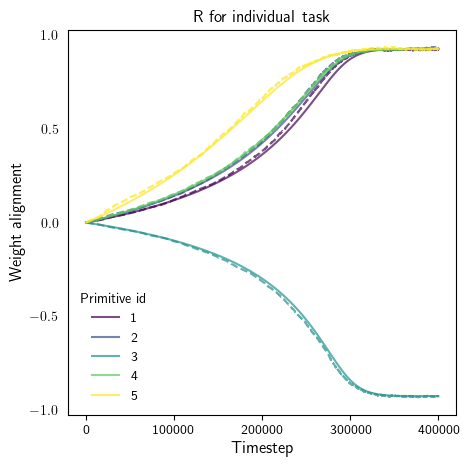

In [383]:
fig=plt.figure(figsize=(5,5))

cmap = matplotlib.cm.get_cmap('viridis')
plt.rcParams['text.usetex'] = True

norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
ax=plt.subplot(111)
K = 5
T= 7
for i in range(K):
    ax.plot(TK_models['indiv'][T,K][:,i,i][:40000], c = cmap(norm(i)), label = i+1 ,alpha = 0.7)
    ax.plot(TK_models_sim['indiv'][T,K][:,i,i][:40000], c = cmap(norm(i)), ls = '--', alpha = 0.7)
plt.title('R for individual task')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'Weight alignment', fontsize=12)
plt.yticks(np.arange(-1.0,1.5,0.5), fontsize=10)
plt.xticks(np.arange(0,50000, 10000), np.arange(0, 500000, 100000), fontsize=10)
ax.yaxis.set_ticks_position('none') 
plt.legend(title = 'Primitive id', frameon = False, loc = 'lower left')

In [380]:
print(TK_models['indiv'][6,K][:,i,i][0])

1.050243263338404e-06


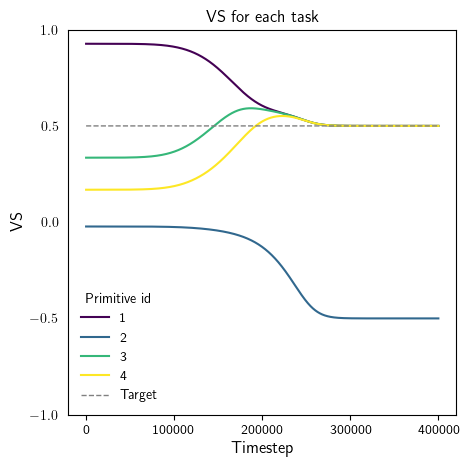

In [379]:
fig=plt.figure(figsize=(5,5))
ax =plt.subplot(111)
for i in range(4):
    ax.plot(TK_models['composite'][6,4]['VS'][:,i][:40000], c = cmap(norm(i)), label = i+1)
    ax.plot(TK_models['composite'][6,4]['VS'][:,i][:40000], c = cmap(norm(i)), label = i+1)
plt.plot(np.arange(40000), np.ones(40000)*0.5, c= 'gray', ls = '--', lw = 1, label = 'Target')
plt.title('VS for each task')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'VS', fontsize=12)
plt.yticks(np.arange(-1.0,1.5,0.5), fontsize=10)
plt.xticks(np.arange(0,50000, 10000), np.arange(0, 500000, 100000), fontsize=10)
ax.yaxis.set_ticks_position('none')
plt.legend(title = 'Primitive id', frameon = False, loc = 'lower left')

/tmp/ipykernel_1920172/515261665.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


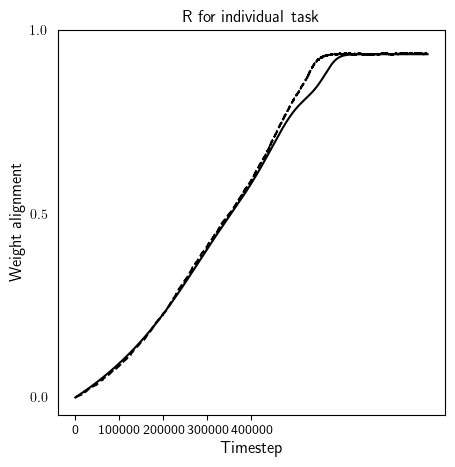

In [354]:
fig=plt.figure(figsize=(5,5))

cmap = matplotlib.cm.get_cmap('viridis')
plt.rcParams['text.usetex'] = True

norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
ax=plt.subplot(111)
ax.plot(TK_models['composite'][8,4]['overlap'][:80000], c = 'k')
ax.plot(TK_models_sim['composite'][8,4]['overlap'][:80000], c = 'k', ls = '--')
plt.title('R for individual task')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'Weight alignment', fontsize=12)
plt.yticks(np.arange(0,1.5,0.5), fontsize=10)
plt.xticks(np.arange(0,50000, 10000), np.arange(0, 500000, 100000), fontsize=10)
ax.yaxis.set_ticks_position('none') 

In [237]:
np.dot(TK_models['composite'][4,8]['VS'][0], np.array([1,0,1,0,1,0,1,0]))/np.linalg.norm(TK_models['composite'][4,8]['VS'][4])/np.linalg.norm(np.array([1,0,1,0,1,0,1,0]))

0.27302715352244894

In [412]:
np.cos(np.pi/3)

0.5000000000000001

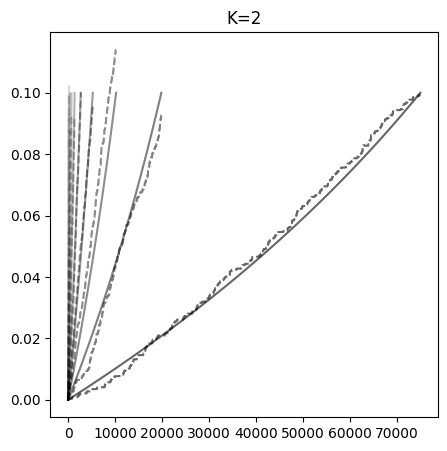

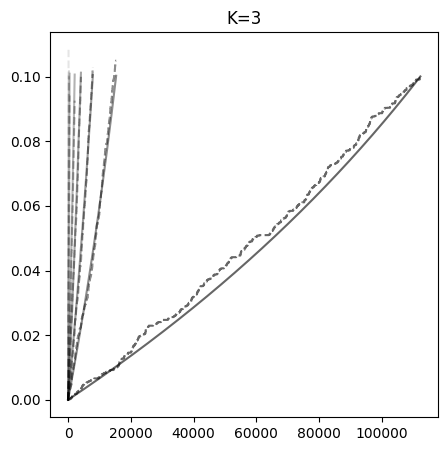

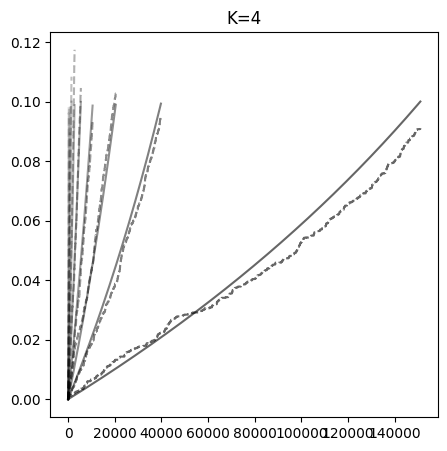

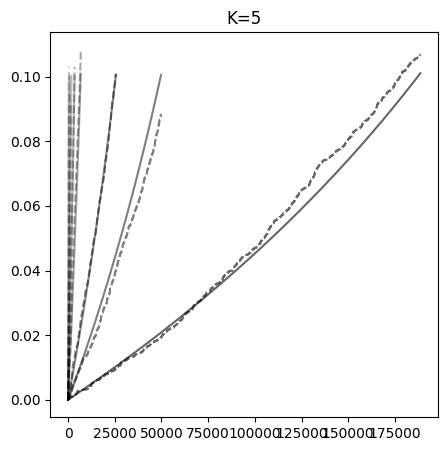

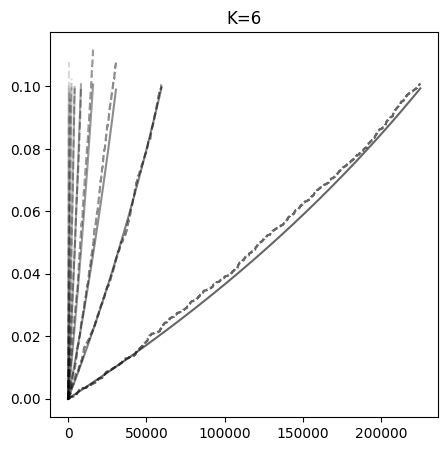

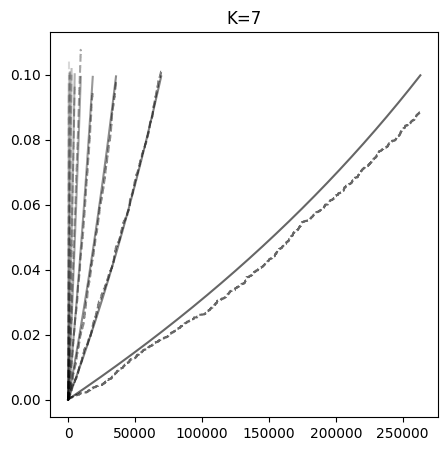

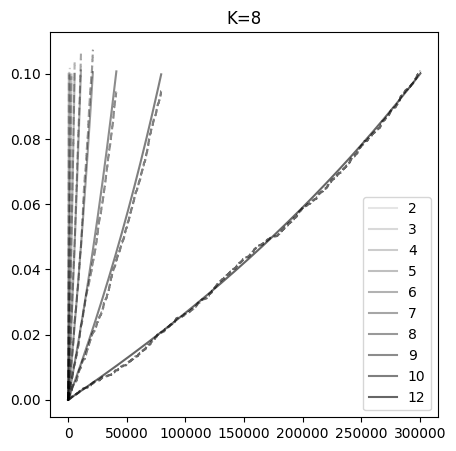

In [103]:
for k in Ks:
    fig=plt.figure(figsize=(5,5))
    plt.title(f'K={k}')
    for t in Ts: 
        try:
            plt.plot(TK_models['composite'][t,k][:int(steps[t,k]//10)], c = 'k', alpha = 0.05*t, label = t)
            plt.plot(TK_models_sim['composite'][t,k][:int(steps[t,k]//10)], ls = '--',  c= 'k', alpha = 0.05*t)
        except:
            pass
plt.legend()

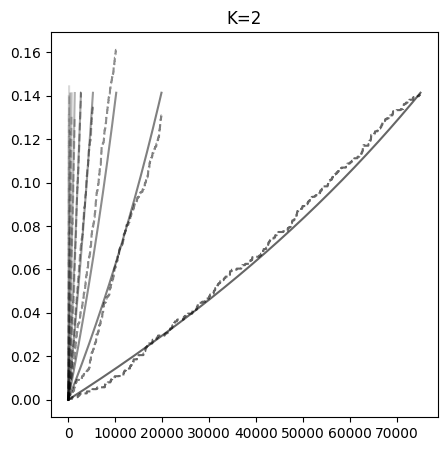

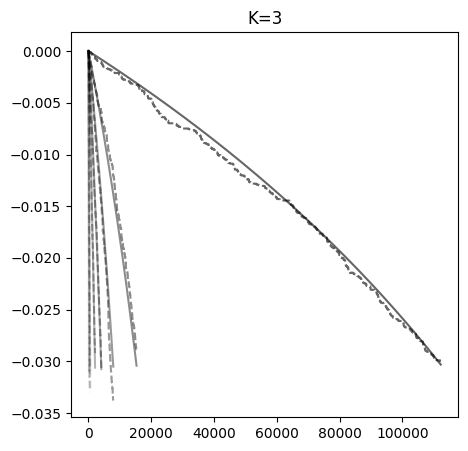

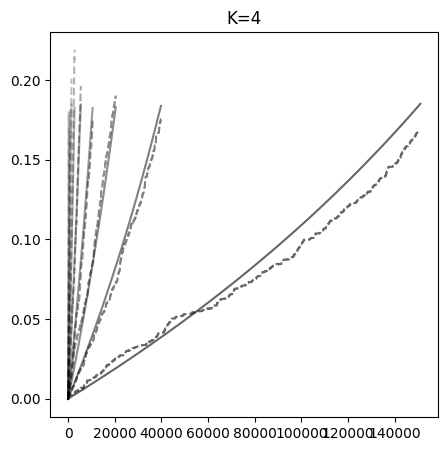

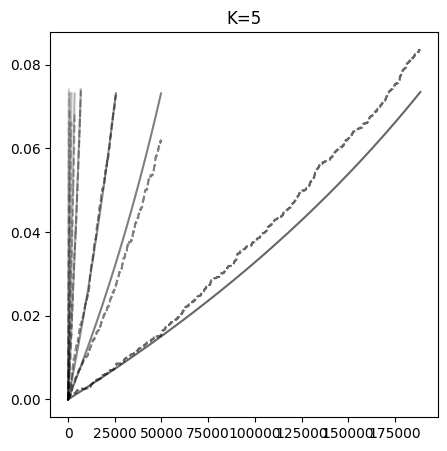

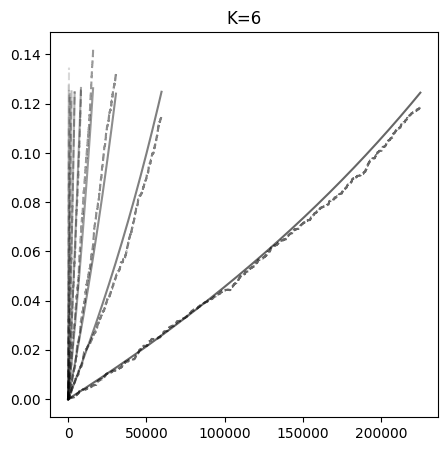

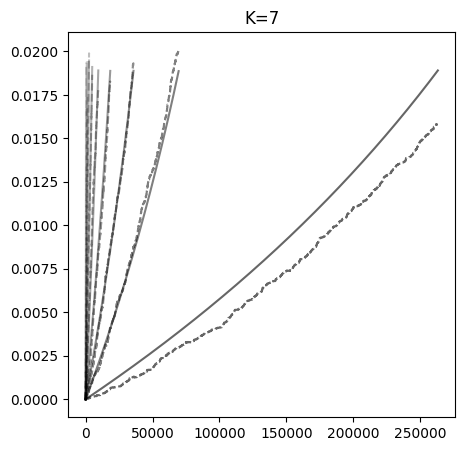

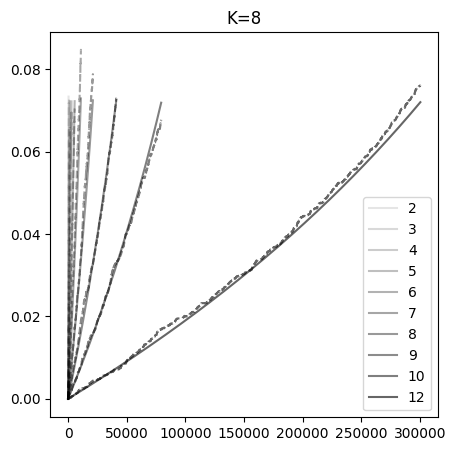

In [107]:
for k in Ks:
    fig=plt.figure(figsize=(5,5))
    plt.title(f'K={k}')
    for t in Ts: 
        try:
            plt.plot(TK_models['indiv'][t,k][:int(steps[t,k]//10),0,0], c = 'k', alpha = 0.05*t, label = t)
            #plt.plot(TK_models['indiv'][t,k][:int(steps[t,k]//10),1,1], c = 'r', alpha = 0.05*t, label = t)
            plt.plot(TK_models_sim['indiv'][t,k][:int(steps[t,k]//10),0,0], ls = '--',  c= 'k', alpha = 0.05*t)
            #plt.plot(TK_models_sim['indiv'][t,k][:int(steps[t,k]//10),1,1], ls = '--',  c= 'r', alpha = 0.05*t)
        except:
            pass
plt.legend()

Text(0.5, 1.0, 'Composite overlap')

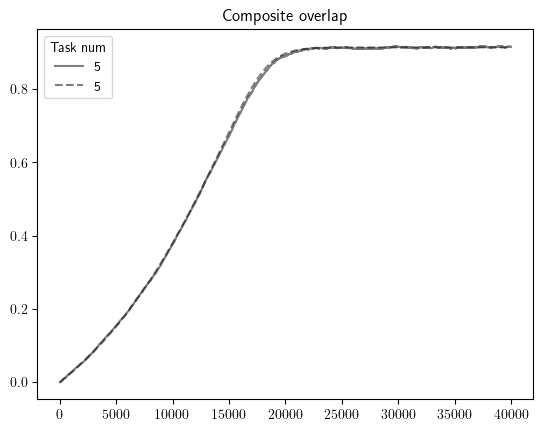

In [410]:
for k in [5]:
    try:
        plt.plot(TK_models_sim['composite'][6,k]['overlap'][:40000], c = 'k', label = k, alpha = k*0.1)
        plt.plot(TK_models['composite'][6,k]['overlap'][:40000], c = 'k', label = k, alpha = k*0.1, ls='--')
    except:
        pass
plt.legend(title = 'Task num')
plt.title('Composite overlap')

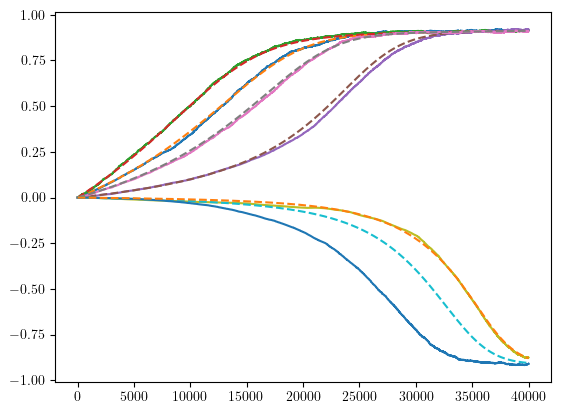

In [406]:
for i in range(6):
    plt.plot(TK_models_sim['indiv'][6,6][:,i,i][:40000])
    plt.plot(TK_models['indiv'][6,6][:,i,i][:40000], ls='--')

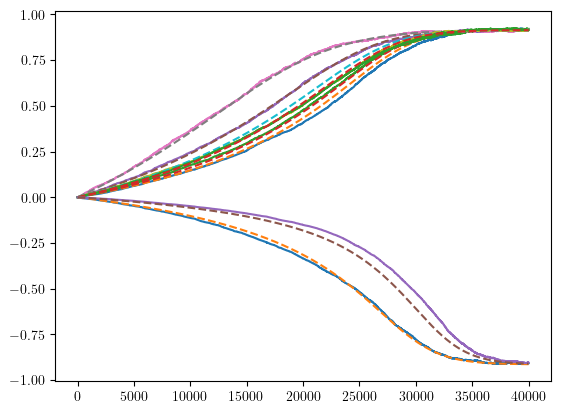

In [407]:
for i in range(8):
    plt.plot(TK_models_sim['indiv'][6,8][:,i,i][:40000])
    plt.plot(TK_models['indiv'][6,8][:,i,i][:40000], ls='--')

In [270]:
[1,1,1,1]/np.linalg.norm([1,1,1,1])

array([0.5, 0.5, 0.5, 0.5])

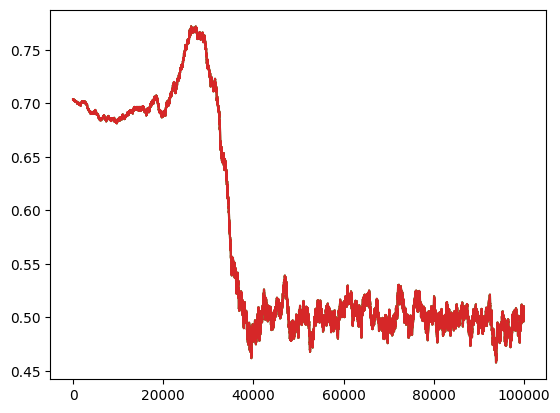

In [131]:
plt.plot(TK_models_sim['composite'][7,4]['V'][:100000])

In [137]:
log_sim['nid']['VS'][-1]

array([ 0.38134105,  0.3881984 ,  0.38490782,  0.37554657, -0.3648836 ,
        0.36976051,  0.38056387])